# Importing Libraries and Directories

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns

from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

directory = "Medical Mask/annotations"
image_directory = "Medical Mask/images"

df = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

In [2]:
prototxtPath = "face_detector/deploy.prototxt"
weightsPath = "face_detector/res10_300x300_ssd_iter_140000.caffemodel"
cvNnet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df = pd.read_csv("train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [7]:
data = []
img_size = 224
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data) 

In [8]:
len(data)

5749

<Axes: xlabel='count'>

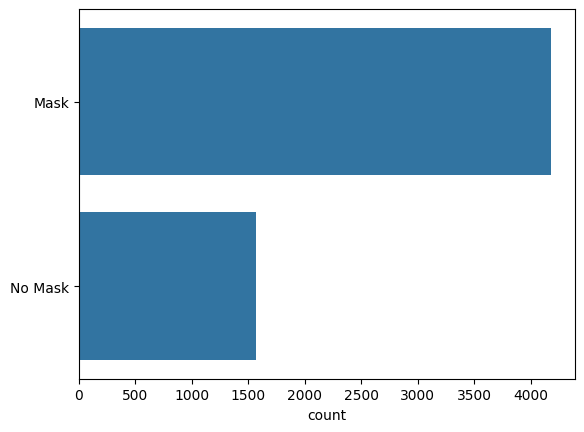

In [9]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [11]:
X[0].shape

(224, 224, 3)

In [12]:
X = np.array(X)/255.0
X = X.reshape(-1,224,224,3)
Y = np.array(Y)

In [13]:
np.unique(Y)

array([0, 1])

In [14]:
Y.shape

(5749,)

# Model Architecture and Training Process

In [15]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________


 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 220, 220, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 128)     0         
                                                                 
 flatten (Flatten)           (None, 1548800)           0         
                                                                 
 dropout_1 (Dropout)         (None, 1548800)           0         
          

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

In [18]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [ ]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
143/143 [==============================] - 25s 119ms/step - loss: 0.3846 - accuracy: 0.8231 - val_loss: 0.2315 - val_accuracy: 0.9278
Epoch 2/50
143/143 [==============================] - 16s 110ms/step - loss: 0.3065 - accuracy: 0.8730 - val_loss: 0.2066 - val_accuracy: 0.9296
Epoch 3/50
143/143 [==============================] - 16s 114ms/step - loss: 0.2912 - accuracy: 0.8820 - val_loss: 0.2614 - val_accuracy: 0.8965
Epoch 4/50
143/143 [==============================] - 16s 112ms/step - loss: 0.2804 - accuracy: 0.8872 - val_loss: 0.2150 - val_accuracy: 0.9287
Epoch 5/50
143/143 [==============================] - 16s 112ms/step - loss: 0.2575 - accuracy: 0.8910 - val_loss: 0.1816 - val_accuracy: 0.9374
Epoch 6/50
143/143 [==============================] - 17s 116ms/step - loss: 0.2651 - accuracy: 0.8964 - val_loss: 0.2170 - val_accuracy: 0.9226
Epoch 7/50
143/143 [==============================] - 17s 119ms/step - loss: 0.2456 - accuracy: 0.9041 - val_loss: 0.1675 - val_ac

# Training and Validation Visualizations

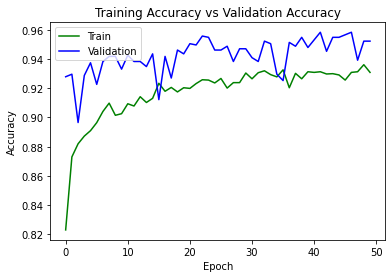

In [ ]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

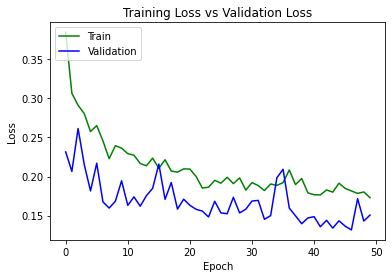

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.save("mask_detector4.model", save_format="h5")

# Model Testing

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


In [ ]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

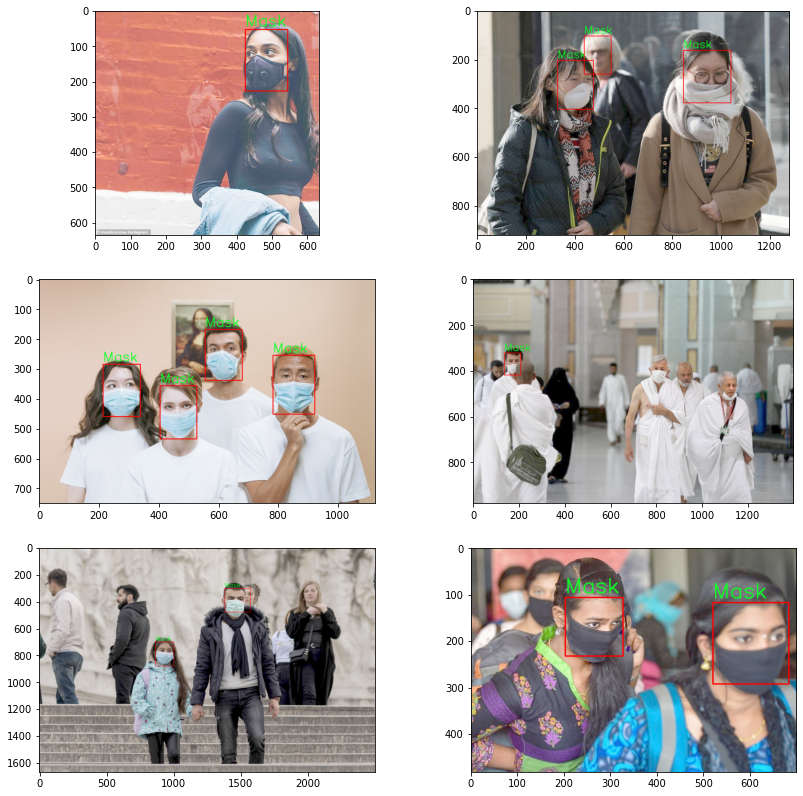

In [ ]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,224,224,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()